In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
jointdf = pd.read_csv("C:/PhD/Rotations/Rotation_1/data/SV2/bedpe/combine/jointdf.bedpe",sep="\t",header=None)
jointdf.columns = ["Chrom1","start1","end1","Chrom2","start2","end2","type","score","samples","Description"]
print(jointdf.type.unique())
jointdf.head()
#order data
jointdf["Chrom1"] = pd.Categorical(jointdf["Chrom1"],categories = ["chr" + n for n in map(str,range(1,23))+["X","Y"]])
ethrank = ['Finnish','SOUTHERN HAN CHINESE','PUERTO RICAN','UTAH/MORMON','YORUBA/Nigeria','HAN CHINESE/China',
           'JAPANESE/Japan','USA/MEXICAN','USA/AFRICAN','ITALY/TOSCANI','Caucasian']
jointdf["Description"] = pd.Categorical(jointdf["Description"],categories = ethrank)
jointdf = jointdf.sort_values(by=["Description","Chrom1","start1"],ascending=True)

['inversion' 'deletion' 'reciprocal' 'inverted-reciprocal'
 'inverted-duplication' 'duplication' 'translocation'
 'inverted-translocation']


## General Visualization

### Number of SV by population

In [3]:
jointdf = pd.read_csv("C:/PhD/Rotations/Rotation_1/data/SV2/bedpe/combine/jointdf.bedpe",sep="\t",header=None)
jointdf.columns = ["Chrom1","start1","end1","Chrom2","start2","end2","type","score","samples","Description"]
a = jointdf.groupby(["Description","samples"]).Chrom1.count().reset_index()
b = jointdf.groupby(["Description"]).samples.nunique().reset_index()
a = pd.merge(a,b,on="Description",how="outer")
a.columns = ["Description","samples","n_event","n_samples_population"]
a = a.sort_values(["n_samples_population","Description"],ascending=False)
ethranka = jointdf.groupby(["Description"]).samples.nunique().reset_index().sort_values(["samples"],ascending=False)
a["Description"] = pd.Categorical(a["Description"],categories=ethranka.loc[:,"Description"])

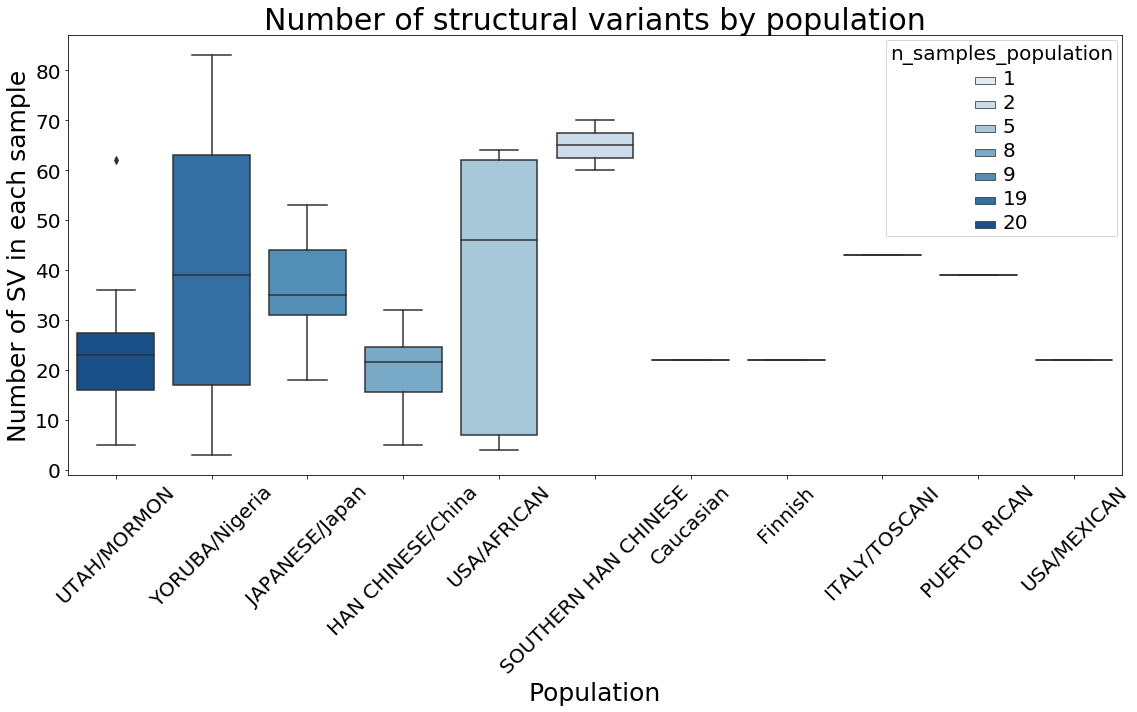

In [4]:
plt.figure(figsize=(16,10))
g = sns.boxplot(x="Description",y="n_event",data = a, hue = "n_samples_population",dodge=False,palette="Blues")
g.axes.set_title("Number of structural variants by population",fontsize=30)
g.set_ylabel("Number of SV in each sample",fontsize=25)
g.set_xlabel("Population",fontsize=25)
g.tick_params(labelsize=20)
plt.xticks(rotation=45)
plt.setp(g.get_legend().get_texts(), fontsize=20) # for legend text
plt.setp(g.get_legend().get_title(), fontsize=20)
plt.tight_layout()
plt.show()
# g.figure.savefig("C:/PhD/Rotations/Rotation_1/writing/plots/pdf/ncontig_population.pdf")

### Components of SV by population

In [5]:
jointdf = pd.read_csv("C:/PhD/Rotations/Rotation_1/data/SV2/bedpe/combine/jointdf.bedpe",sep="\t",header=None)
jointdf.columns = ["Chrom1","start1","end1","Chrom2","start2","end2","type","score","samples","Description"]
a = jointdf.groupby(["Description","type"]).start1.count().reset_index()
b = jointdf.groupby(["Description"]).start1.count().reset_index()
a = pd.merge(a,b,on="Description",how="outer")
a.columns = ["Description","type","n_SV","total_SV"]
a.loc[:,"SV_perc"] = a.loc[:,"n_SV"] / a.loc[:,"total_SV"]
a = a.sort_values(["Description","type"])
a.loc[:,"SV_sum_perc"] = a.groupby(["Description"]).SV_perc.cumsum()
a = a.sort_values(["Description","SV_sum_perc"],ascending = False)

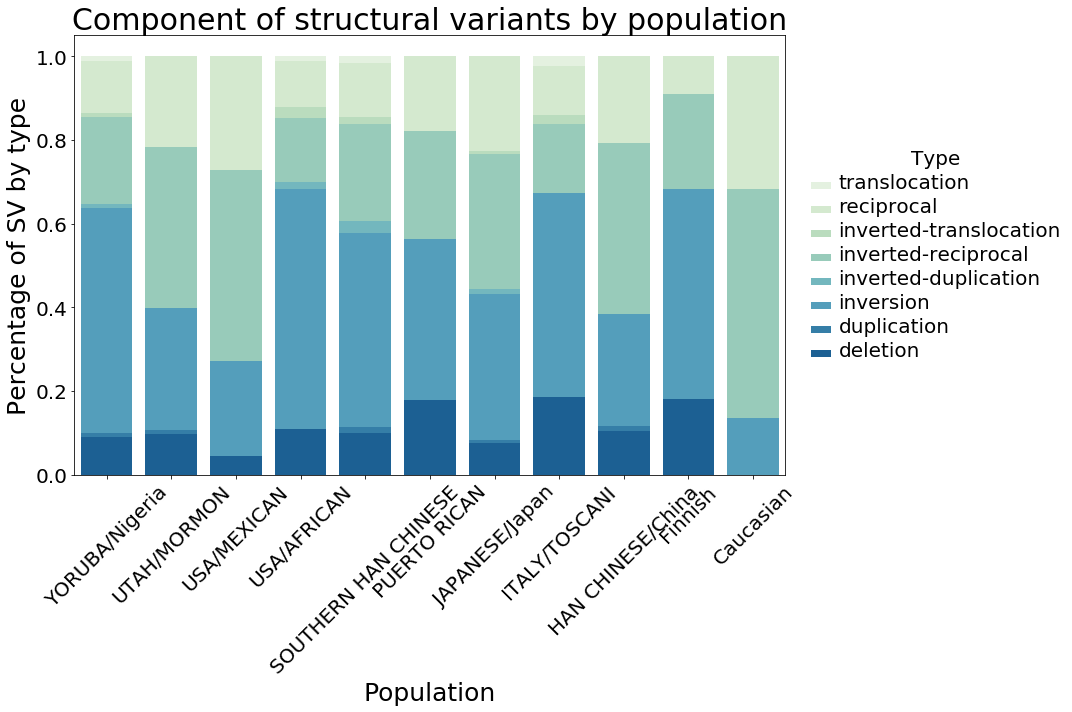

In [6]:
plt.figure(figsize=(16,10))
g = sns.barplot(x="Description",y="SV_sum_perc",data = a, hue = "type",dodge=False,palette="GnBu") #GnBu_d is reverse
g.axes.set_title("Component of structural variants by population",fontsize=30)
g.set_ylabel("Percentage of SV by type",fontsize=25)
g.set_xlabel("Population",fontsize=25)
g.tick_params(labelsize=20)
g.legend(frameon=False,title="Type",loc='center right', bbox_to_anchor=(1.4, 0.5), ncol=1)
plt.xticks(rotation=45)
plt.setp(g.get_legend().get_texts(), fontsize=20) # for legend text
plt.setp(g.get_legend().get_title(), fontsize=20)
plt.tight_layout()
plt.show()

### Number of SV - PCA

[0.44985165 0.18040116 0.14994141]


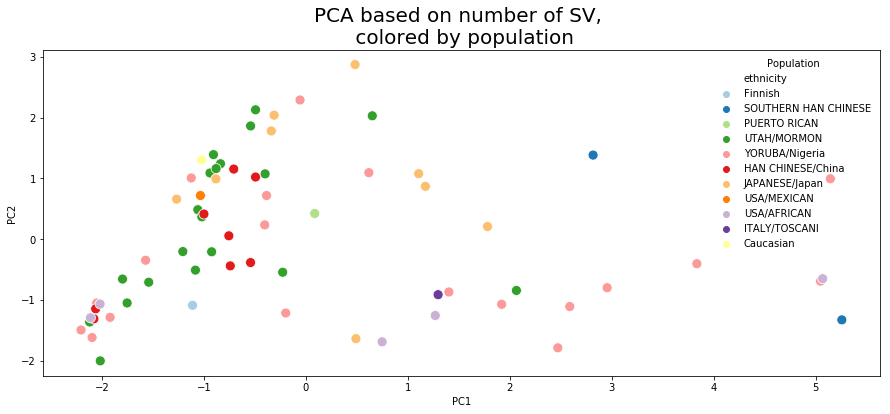

In [7]:
sumdf = jointdf.groupby(["Description","samples","type"]).start1.count().reset_index()
sumdf2 = sumdf.pivot("samples","type","start1").fillna(0)

#PCA
X = sumdf2.iloc[:,:].values
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
pca = PCA(n_components = 3)
pc = pca.fit_transform(X)
pcdf = pd.concat([pd.Series(list(sumdf2.index)), pd.DataFrame(pc)], axis=1)
pcdf.columns = ["samples","PC1","PC2","PC3"]

print(pca.explained_variance_ratio_)

#ethnicity information
ethdf = pd.read_excel("C:/PhD/Rotations/Rotation_1/70_samples.xlsx")
ethdf = ethdf.iloc[:,[0,1]]
ethdf.columns = ["samples","ethnicity"]
ethdf["samples"] = ethdf.loc[:,"samples"].str.split("_",n=1,expand=True).loc[:,1]
pcdf = pd.merge(pcdf,ethdf,on="samples",how="outer")
pcdf2 = pd.merge(pcdf,sumdf2,on="samples",how="outer")

#Visualization
# plt.figure(figsize=(16,10))
plt.figure(figsize=(15,6))
g = sns.scatterplot("PC1","PC2",hue="ethnicity",data=pcdf2,palette="Paired",s=100)
g.axes.set_title("PCA based on number of SV, \n colored by population",size=20)
g.legend(frameon=False,title="Population")
plt.show()

## Bin genome - SV hotspot

In [125]:
bindf = jointdf
bindf['location1'] = bindf['start1'].apply(lambda x: x/(1000000))
bindf['location2'] = bindf['start2'].apply(lambda x: x/(1000000)) #1Mb 
bindf.head()

,Chrom1,start1,end1,Chrom2,start2,end2,type,score,samples,Description,location1,location2
0,chr1,104171777,104170258,chr1,104266694,104266163,inversion,73,HG00276,Finnish,104,104
2,chr1,149266252,149266280,chr1,149651969,149650856,inversion,19,HG00276,Finnish,149,149
1,chr1,149334889,149334380,chr1,149722886,149721259,inversion,24,HG00276,Finnish,149,149
3,chr2,87573422,87571824,chr2,91762909,91761936,inversion,14,HG00276,Finnish,87,91
4,chr2,89122655,89132244,chr2,89521742,89530369,deletion,6,HG00276,Finnish,89,89


In [126]:
#hotspot for from
hsfrom = bindf.groupby(["Chrom1","location1","type"]).samples.nunique().reset_index()
hsfrom.head()

,Chrom1,location1,type,samples
0,chr1,12,inversion,1
1,chr1,13,deletion,7
2,chr1,16,inversion,17
3,chr1,17,duplication,3
4,chr1,17,inverted-duplication,5


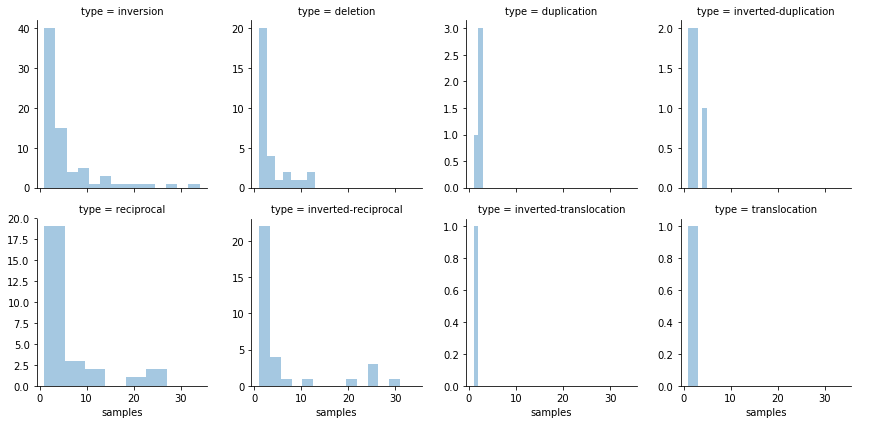

In [116]:
# sns.distplot(hsfrom.loc[:,"samples"])
g = sns.FacetGrid(hsfrom, col="type",col_wrap=4,margin_titles=True,sharey=False,sharex=True)
g = (g.map(sns.distplot,"samples",kde=False).add_legend())

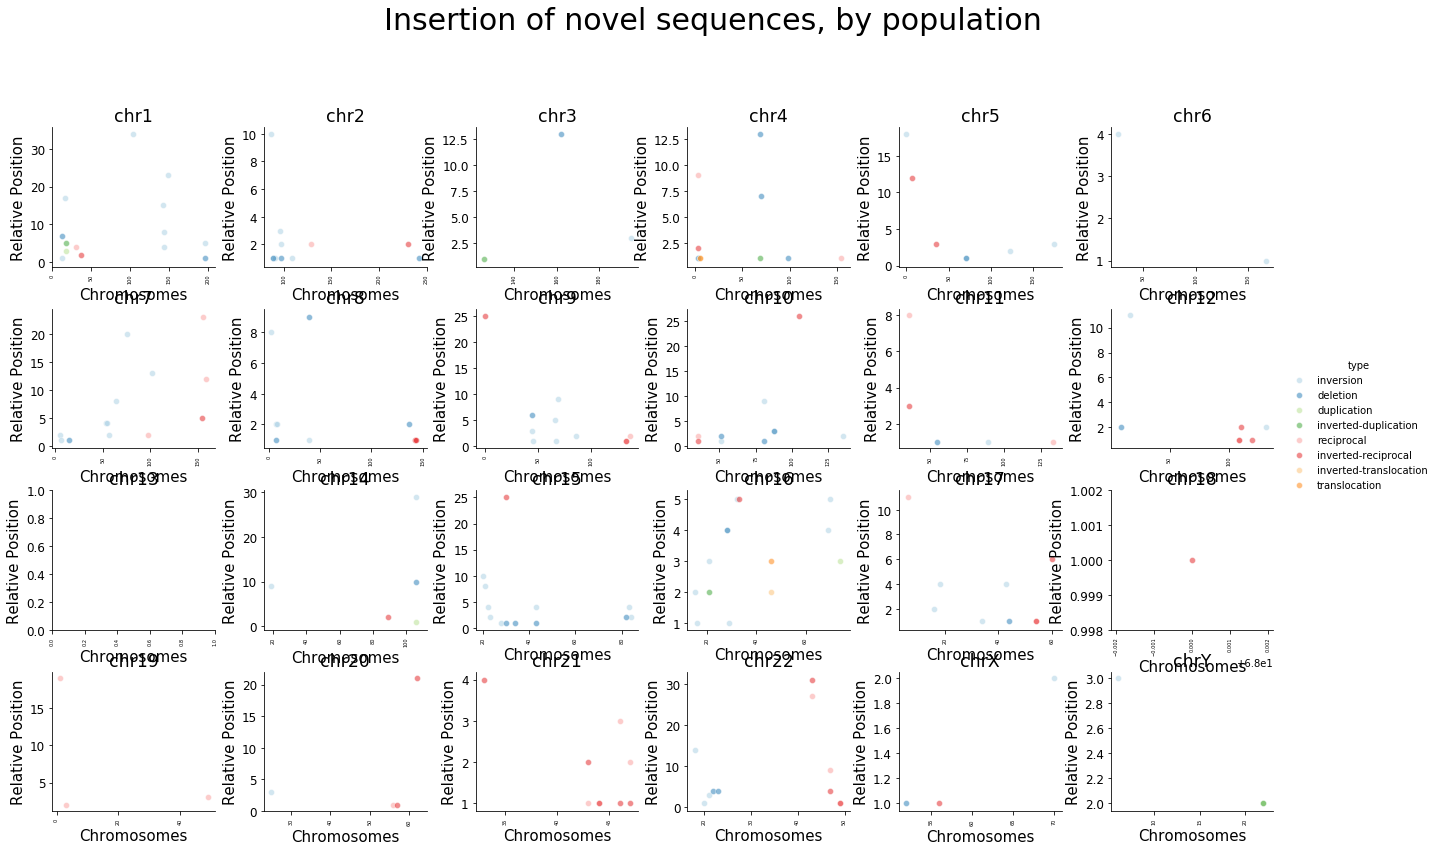

In [111]:
g = sns.FacetGrid(hsfrom, col="Chrom1",col_wrap=6,margin_titles=True,
                  hue="type",palette = 'Paired',sharey=False,sharex=False)
g = (g.map(sns.scatterplot,"location1","samples",alpha=0.5).add_legend())
g.set_titles('{col_name}')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_fontsize(5)
    for label in ax.get_yticklabels():
        label.set_fontsize(12)
    ax.set_xlabel("Chromosomes",fontsize=15)
    ax.set_ylabel("Relative Position",fontsize=15)
    ax.set_title(ax.get_title(),fontsize="xx-large")
g.fig.suptitle("Insertion of novel sequences, by population",size=30)
g.fig.subplots_adjust(top=0.84)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

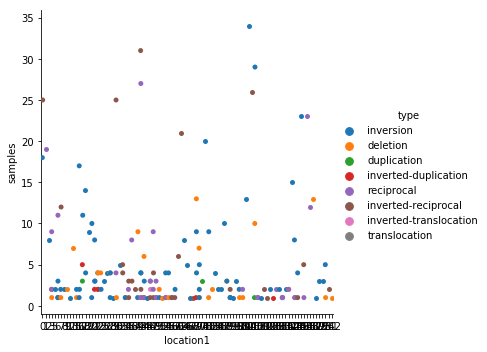

In [100]:
sns.catplot(x="location1",y="samples",hue="type",data=hsfrom)

## Inversion and Deletion 

In [46]:
sub = jointdf[jointdf["type"].isin(["inversion","deletion"])]
sub.loc[:,"start"] = jointdf[['start1','end1']].min(axis=1)
sub.loc[:,"end"] = jointdf[['start2','end2']].min(axis=1)
sub.loc[:,"length"] = sub.loc[:,"end"] - sub.loc[:,"start"]
print(all(sub["Chrom1"]==sub["Chrom2"]))
sub.head()

True


,Chrom1,start1,end1,Chrom2,start2,end2,type,score,samples,Description,start,end,length
0,chr1,104171777,104170258,chr1,104266694,104266163,inversion,73,HG00276,Finnish,104170258,104266163,95905
1,chr1,149334889,149334380,chr1,149722886,149721259,inversion,24,HG00276,Finnish,149334380,149721259,386879
2,chr1,149266252,149266280,chr1,149651969,149650856,inversion,19,HG00276,Finnish,149266252,149650856,384604
3,chr2,87573422,87571824,chr2,91762909,91761936,inversion,14,HG00276,Finnish,87571824,91761936,4190112
4,chr2,89122655,89132244,chr2,89521742,89530369,deletion,6,HG00276,Finnish,89122655,89521742,399087


In [50]:
sub.length.describe()

count    5.700000e+02
mean     7.857708e+05
std      1.333448e+06
min      8.553300e+04
25%      1.199390e+05
50%      2.323095e+05
75%      6.982960e+05
max      9.459609e+06
Name: length, dtype: float64

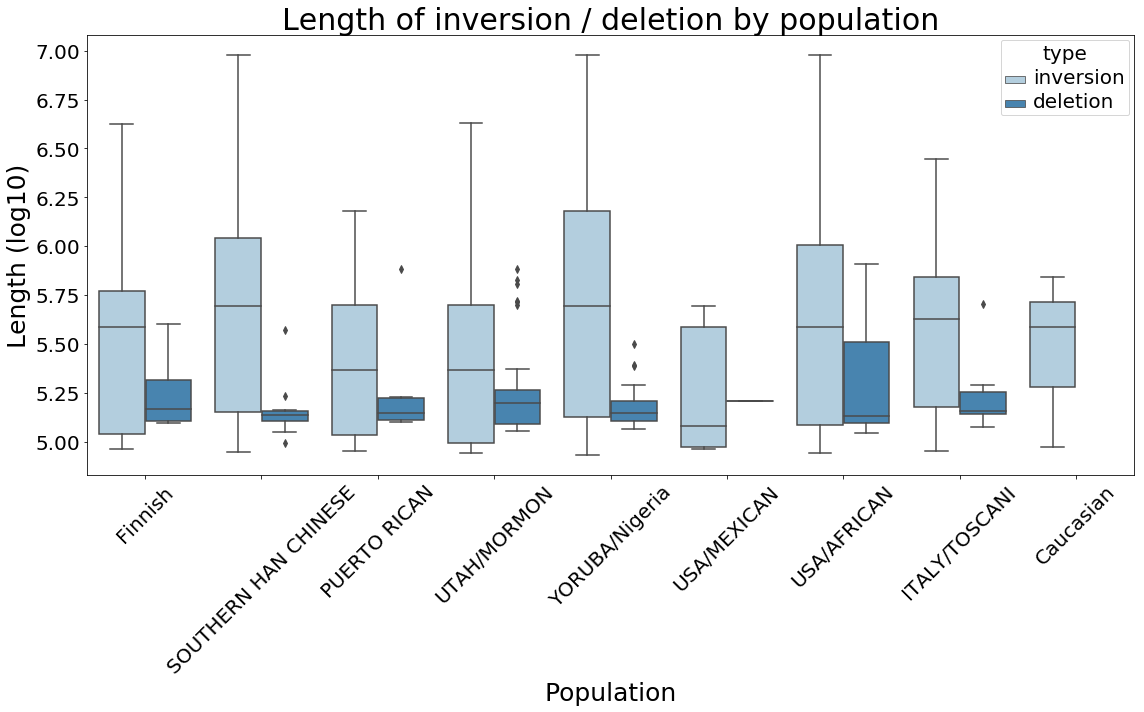

In [45]:
a = sub #[sub["type"]=="inversion"]
a.loc[:,"log_length"] = np.log10(a.loc[:,"length"])
plt.figure(figsize=(16,10))
g = sns.boxplot(x="Description",y="log_length",data = a, hue="type", dodge=True,palette="Blues")
g.axes.set_title("Length of inversion / deletion by population",fontsize=30)
g.set_ylabel("Length (log10)",fontsize=25)
g.set_xlabel("Population",fontsize=25)
g.tick_params(labelsize=20)
plt.xticks(rotation=45)
plt.setp(g.get_legend().get_texts(), fontsize=20) # for legend text
plt.setp(g.get_legend().get_title(), fontsize=20)
plt.tight_layout()
plt.show()

In [45]:
# bin genome
chrs = ["chr" + n for n in map(str,range(1,23))+["X","Y"]]
for chri in chrs:
    chrdata = sub[sub["Chrom1"]==chri]
    


['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrX',
 'chrY']

In [41]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 3)

[(0.994, 3.0], (5.0, 7.0], (3.0, 5.0], (3.0, 5.0], (5.0, 7.0], (0.994, 3.0]]
Categories (3, interval[float64]): [(0.994, 3.0] < (3.0, 5.0] < (5.0, 7.0]]

In [40]:
sub.describe()
sub.head()

,Chrom1,start1,end1,Chrom2,start2,end2,type,score,samples,Description,start,end,length
0,chr1,104171777,104170258,chr1,104266694,104266163,inversion,73,HG00276,Finnish,104170258,104266163,95905
1,chr1,149334889,149334380,chr1,149722886,149721259,inversion,24,HG00276,Finnish,149334380,149721259,386879
2,chr1,149266252,149266280,chr1,149651969,149650856,inversion,19,HG00276,Finnish,149266252,149650856,384604
3,chr2,87573422,87571824,chr2,91762909,91761936,inversion,14,HG00276,Finnish,87571824,91761936,4190112
4,chr2,89122655,89132244,chr2,89521742,89530369,deletion,6,HG00276,Finnish,89122655,89521742,399087


## Reciprocal, Duplication and Translocation (including inverted)

In [8]:
sub = jointdf[jointdf["type"].isin(["inversion","deletion"])]
sub1 = jointdf[~jointdf["type"].isin(["inversion","deletion"])]
print(sub1.shape[0] + sub.shape[0])
print(jointdf.shape)

sub1.loc[:,"length1"] = abs(sub1.loc[:,"start1"] - sub1.loc[:,"end1"])
sub1.loc[:,"length2"] = abs(sub1.loc[:,"start2"] - sub1.loc[:,"end2"])
sub1.length1.describe()

2202
(2202, 10)


C:\Users\yangr\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\yangr\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    1.052000e+03
mean     9.618476e+04
std      5.696238e+05
min      1.341000e+03
25%      5.042500e+03
50%      1.619350e+04
75%      3.258975e+04
max      6.812290e+06
Name: length1, dtype: float64

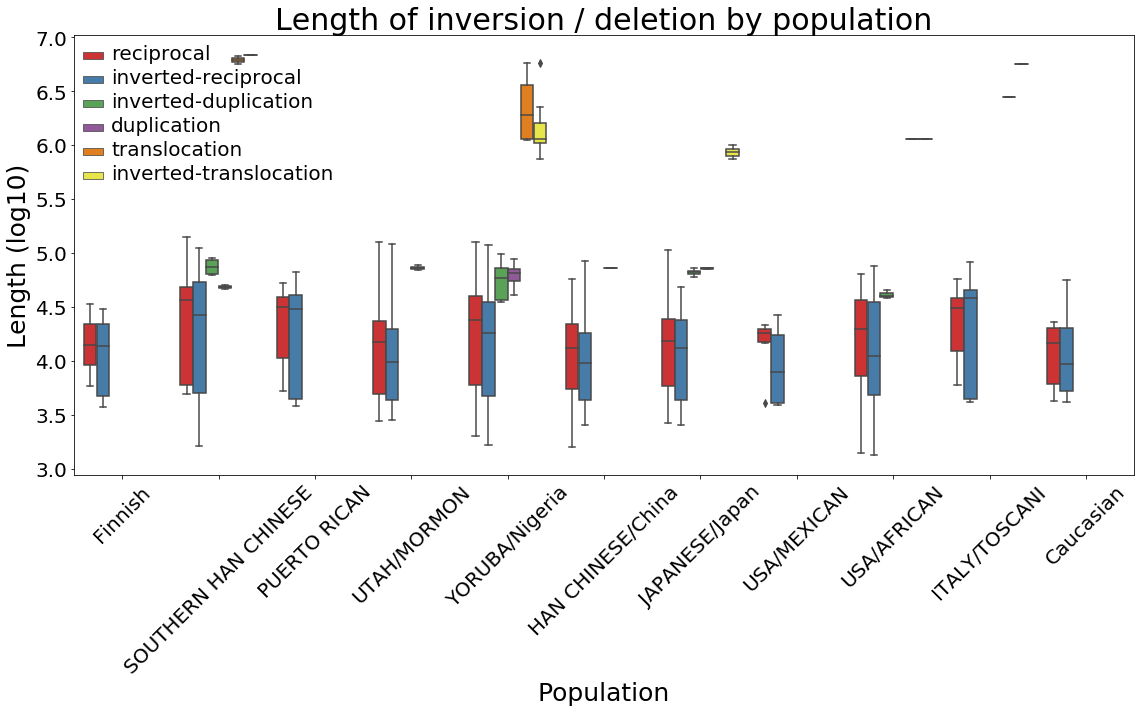

In [9]:
a = sub1 #[sub["type"]=="inversion"]
a.loc[:,"log_length1"] = np.log10(a.loc[:,"length1"])
a.loc[:,"log_length2"] = np.log10(a.loc[:,"length2"])
plt.figure(figsize=(16,10))
g = sns.boxplot(x="Description",y="log_length1",data = a, hue="type", dodge=True,palette="Set1")
g.axes.set_title("Length of inversion / deletion by population",fontsize=30)
g.set_ylabel("Length (log10)",fontsize=25)
g.set_xlabel("Population",fontsize=25)
g.tick_params(labelsize=20)
# g.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), ncol=1,frameon=False)
g.legend(frameon=False)
plt.xticks(rotation=45)
plt.setp(g.get_legend().get_texts(), fontsize=20) # for legend text
plt.setp(g.get_legend().get_title(), fontsize=20)
plt.tight_layout()
plt.show()